# MVSA-Single Text Sentiment Classification (TF‑IDF + Logistic Regression)
### Preprocessing Ablation Study (Raw vs. Individual Steps vs. Full Pipeline)

This notebook implements a **text-only** sentiment classification framework on the **MVSA-Single** dataset. It conducts a **controlled ablation study** to measure how specific preprocessing steps impact the performance of a **Logistic Regression** classifier.

## Objectives
- **Model Baseline**: Establish a baseline using a Logistic Regression classifier on raw text.
- **Ablation Study**: Compare **Raw text** against **individual preprocessing steps** and a **Full Preprocessing Pipeline** on the same English subset.
- **Performance Metrics**: Evaluate improvements using **Accuracy** and **Macro-F1** score (chosen for its robustness in class-imbalanced scenarios).

## Experimental Design
All experiments maintain consistent control variables:
- **Dataset**: Identical English subset.
- **Split**: Stratified Train/Test split with a fixed random seed.
- **Features**: Consistent TF-IDF vectorization settings.
- **Model**: Fixed Logistic Regression hyperparameters.

We isolate and vary a **single factor** in each experiment (with the exception of the **Full** pipeline, which aggregates all methods).

|   ID   | Description                                           | Text Transform | Training Strategy         |
|:------:|-------------------------------------------------------|----------------|---------------------------|
| **E0** | Baseline (Raw English subset)                         | None           | None                      |
| **E1** | Noise Removal (Remove `@/#/url`)                      | ✅              | None                      |
| **E2** | Normalization (Slang expansion)                       | ✅              | None                      |
| **E3** | Class Balancing                                       | None           | `class_weight="balanced"` |
| **E4** | **FULL Pipeline** (Noise Removal + Slang + Balancing) | ✅              | `class_weight="balanced"` |

---

In [124]:
# =========================
# 1) Setup & Imports
# =========================
# This notebook is designed to be reproducible:
# - Fixed random seed for splitting
# - Deterministic language detection seed (if langdetect is installed)
# - All key parameters are defined in one place

import os
import re
from pathlib import Path
from typing import Dict, Callable, Optional, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Make langdetect deterministic if available
try:
    from langdetect import DetectorFactory
    DetectorFactory.seed = 0
except Exception:
    pass

print("Imports complete.")

Imports complete.


## 2) Load MVSA-Single Dataset (Text + Sentiment Labels)

The dataset is sourced from [Kaggle: MVSA-Single](https://www.kaggle.com/datasets/vincemarcs/mvsasingle).

The MVSA-Single dataset structure typically consists of:
- `labelResultAll.txt`: A tab-separated file containing labels for each sample ID (format: `text_sentiment, image_sentiment`).
- `data/<ID>.txt`: Individual text files containing the raw tweet content.

**Data Loading Pipeline:**
1.  **Download**: Retrieve the dataset programmatically.
2.  **Parse Labels**: Extract the **text sentiment** label (the first value in the `text,image` pair).
3.  **Read Content**: Ingest tweet texts from the `data/*.txt` files.
4.  **Merge**: Consolidate data into a single DataFrame `(ID, text, label)`.

> **Note**: This project focuses exclusively on **text-based** sentiment analysis.

In [125]:
# =========================
# 2) Dataset Extraction
# =========================

import kagglehub

# Download latest version
path = kagglehub.dataset_download("vincemarcs/mvsasingle")

print("Path to dataset files:", path)

MVSA_ROOT = Path(os.path.join(path, "MVSA_Single"))
LABEL_FILE = Path(os.path.join(MVSA_ROOT, "labelResultAll.txt"))
DATA_DIR = Path(os.path.join(MVSA_ROOT, "data"))

print("MVSA_ROOT:", MVSA_ROOT)
print("LABEL_FILE:", LABEL_FILE)
print("DATA_DIR:", DATA_DIR)

# Load label file: columns are typically ["ID", "text,image"]
labels = pd.read_csv(LABEL_FILE, sep="\t", engine="python")
labels.columns = [c.strip() for c in labels.columns]

# Extract *text* sentiment label from "text,image" column
# Example row: "neutral,positive"  -> text label = "neutral"
labels["label"] = labels["text,image"].astype(str).str.split(",").str[0].str.strip().str.lower()
labels["ID"] = labels["ID"].astype(int)
labels = labels.dropna(subset=["label"])

# Load texts from data/*.txt
rows = []
id_pattern = re.compile(r"^(\d+)\.txt$")

for p in DATA_DIR.glob("*.txt"):
    m = id_pattern.match(p.name)
    if not m:
        continue
    _id = int(m.group(1))
    # Tweets can contain emojis or unusual chars; ignore decoding errors safely
    text = p.read_text(encoding="utf-8", errors="ignore").strip()
    rows.append((_id, text))

texts = pd.DataFrame(rows, columns=["ID", "text"])

# Merge text + label
df = texts.merge(labels[["ID", "label"]], on="ID", how="inner")
df = df[["text", "label"]].dropna().reset_index(drop=True)

print("Merged dataset shape:", df.shape)
df.head()

Path to dataset files: C:\Users\mhjv_\.cache\kagglehub\datasets\vincemarcs\mvsasingle\versions\1
MVSA_ROOT: C:\Users\mhjv_\.cache\kagglehub\datasets\vincemarcs\mvsasingle\versions\1\MVSA_Single
LABEL_FILE: C:\Users\mhjv_\.cache\kagglehub\datasets\vincemarcs\mvsasingle\versions\1\MVSA_Single\labelResultAll.txt
DATA_DIR: C:\Users\mhjv_\.cache\kagglehub\datasets\vincemarcs\mvsasingle\versions\1\MVSA_Single\data
Merged dataset shape: (4869, 2)


,text,label
0,How I feel today #legday #jelly #aching #gym,neutral
1,@ArrivaTW absolute disgrace two carriages from...,negative
2,This is my Valentine's from 1 of my nephews. I...,positive
3,betterfeelingfilms: RT via Instagram: First da...,positive
4,Zoe's first love #Rattled @JohnnyHarper15,positive


## 3) Exploratory Data Analysis (EDA)

We perform a brief analysis to inspect:
- **Class Distribution**: Identifying potential class imbalance.
- **Sample Quality**: Reviewing random samples to understand noise levels (e.g., mentions, hashtags, URLs, slang).
- **Text Length Analysis**: Investigating whether the length of the text correlates with specific sentiment labels (e.g., are negative tweets longer?).

This step is crucial for determining the necessity of specific preprocessing techniques and understanding feature separability.

In [126]:
# Label distribution
label_counts = df["label"].value_counts()
label_dist = (label_counts / len(df)).round(4)

display(pd.DataFrame({"count": label_counts, "ratio": label_dist}))

# Show a few random examples
df.sample(5, random_state=RANDOM_STATE)

# Text Length Analysis
from sklearn.preprocessing import LabelEncoder

temp_df = df.copy()
temp_df['text_length'] = temp_df['text'].apply(str).apply(len)
le = LabelEncoder()
temp_df['target_code'] = le.fit_transform(temp_df['label'])

corr = temp_df[['text_length', 'target_code']].corr()
print(corr)

,count,ratio
label,,
neutral,1921,0.3945
positive,1731,0.3555
negative,1217,0.2499


             text_length  target_code
text_length     1.000000     0.032547
target_code     0.032547     1.000000


### Word Cloud Visualization
To intuitively understand the distinctive vocabulary associated with each sentiment, we generate **Word Clouds** for the *Negative*, *Neutral*, and *Positive* classes. This visualization highlights the most frequent tokens, allowing us to qualitatively inspect whether specific keywords (e.g., adjectives, topic-specific terms) are strongly correlated with ground-truth labels.

negative:


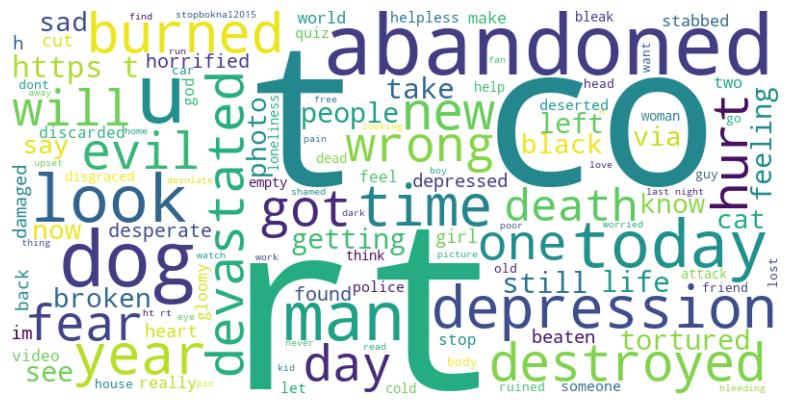

neutral:


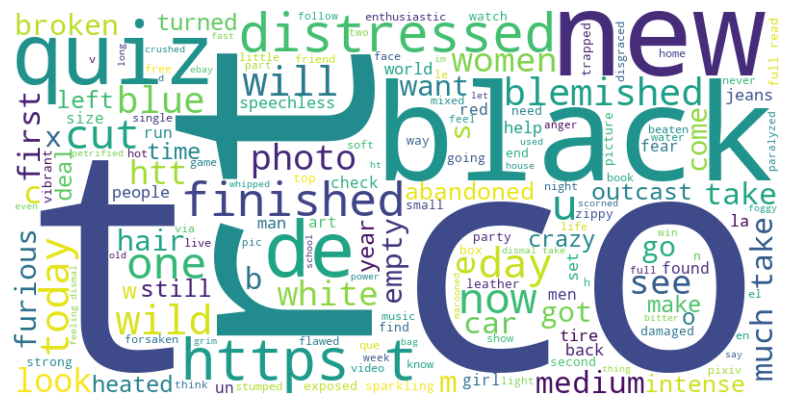

positive:


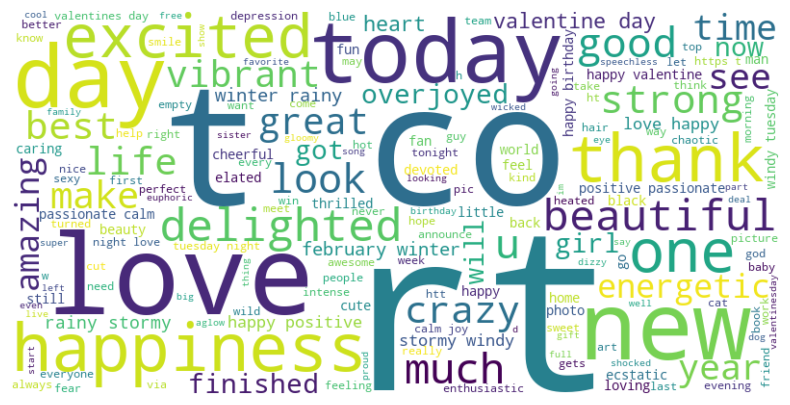

In [127]:
from wordcloud import WordCloud

all_neutral_words = ' '.join(df[df['label'] == 'neutral']['text'].str.lower())
all_positive_words = ' '.join(df[df['label'] == 'positive']['text'].str.lower())
all_negative_words = ' '.join(df[df['label'] == 'negative']['text'].str.lower())

def plt_word_cloud(all_word):
  wordcloud = WordCloud(width=800, height=400,
                      background_color='white',
                      min_font_size=10).generate(all_word)

  # 4. Display the generated image
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off") # Hide the axes
  plt.show()

print("negative:")
plt_word_cloud(all_negative_words)
print("neutral:")
plt_word_cloud(all_neutral_words)
print("positive:")
plt_word_cloud(all_positive_words)

## 4) English Subset Filtering

The MVSA-Single dataset is multilingual. To ensure experimental validity and align with project requirements, we filter the dataset to retain only an **English subset**. All subsequent ablation experiments are performed on this filtered subset.

**Filtering Logic:**
- **Primary Method**: Use `langdetect` (if installed) for robust language identification.
- **Fallback Method**: Use a heuristic based on **ASCII character ratio** if `langdetect` is unavailable.

In [128]:
# =========================
# 4) English Detection Helpers
# =========================

_whitespace_re = re.compile(r"\s+")

def normalize_text_basic(text: str) -> str:
    # Minimal normalization shared by all experiments:
    # - Replace line breaks with spaces
    # - Collapse repeated whitespace
    # - Trim leading/trailing spaces
    text = "" if text is None else str(text)
    text = text.replace("\r", " ").replace("\n", " ")
    text = _whitespace_re.sub(" ", text).strip()
    return text

def is_english_langdetect(text: str) -> Optional[bool]:
    # Return True/False using langdetect if available.
    # Return None if langdetect is not installed.
    try:
        from langdetect import detect
    except Exception:
        return None

    t = normalize_text_basic(text)
    if len(t) < 3:
        return False
    try:
        return detect(t) == "en"
    except Exception:
        # langdetect can fail on very short or noisy strings
        return False

def is_english_ascii_heuristic(text: str, threshold: float = 0.90) -> bool:
    # Fallback heuristic:
    # - Count the fraction of ASCII characters
    # - If ratio >= threshold, treat as English-like
    t = normalize_text_basic(text)
    if not t:
        return False
    ascii_chars = sum(1 for c in t if ord(c) < 128)
    return (ascii_chars / max(1, len(t))) >= threshold

def is_english(text: str) -> bool:
    r = is_english_langdetect(text)
    if r is None:
        return is_english_ascii_heuristic(text)
    return bool(r)

# Apply English filtering
df["is_english"] = df["text"].apply(is_english)
df_en = df.loc[df["is_english"]].drop(columns=["is_english"]).reset_index(drop=True)

print("Before English filter:", len(df))
print("After English filter:", len(df_en))

display(df_en["label"].value_counts())

Before English filter: 4869
After English filter: 4803


label
neutral     1857
positive    1729
negative    1217
Name: count, dtype: int64

## 5) Preprocessing Modules

We implement modular preprocessing functions to be used selectively in the ablation experiments:

### (A) Noise Removal (Social Tokens)
Removes platform-specific artifacts that may introduce noise:
- `@mentions` (Usernames)
- `#hashtags` (Topics)
- `http/https` (URLs)

### (B) Slang Expansion (Normalization)
Normalizes non-standard internet slang into standard English using a predefined dictionary mapping:
- *Example*: `lol` $\rightarrow$ `laugh out loud`, `idk` $\rightarrow$ `i do not know`.

### (C) Full Pipeline (E4)
A composite pipeline that applies:
1.  Social token removal.
2.  Slang expansion.
3.  (During Training) Class weighting.

In [129]:
# =========================
# 5) Preprocessing Functions
# =========================

# Token pattern: sequences of non-space characters
_token_re = re.compile(r"\b\S+\b", flags=re.UNICODE)

def remove_social_tokens(text: str) -> str:
    # Remove tokens that start with '@', '#', or 'http'.
    # This is common for tweet-like data where mentions/hashtags/URLs can add noise.
    t = normalize_text_basic(text)
    tokens = _token_re.findall(t)
    kept = []
    for tok in tokens:
        low = tok.lower()
        if low.startswith("@") or low.startswith("#") or low.startswith("http"):
            continue
        kept.append(tok)
    return " ".join(kept)

# A small, editable slang dictionary (you can extend this list as needed)
SLANG_DICT: Dict[str, str] = {
    "lol": "laugh out loud",
    "lmao": "laughing my ass off",
    "rofl": "rolling on the floor laughing",
    "idk": "i do not know",
    "imo": "in my opinion",
    "imho": "in my humble opinion",
    "omg": "oh my god",
    "btw": "by the way",
    "brb": "be right back",
    "ttyl": "talk to you later",
    "thx": "thanks",
    "u": "you",
    "ur": "your",
    "pls": "please",
    "plz": "please",
    "w/": "with",
    "w/o": "without",
}

# Lowercase keys for case-insensitive matching
SLANG_DICT = {k.lower(): v for k, v in SLANG_DICT.items()}

def expand_slang(text: str, slang: Dict[str, str] = SLANG_DICT) -> str:
    # Replace slang tokens by dictionary expansion (token-by-token).
    t = normalize_text_basic(text)
    tokens = _token_re.findall(t)
    out = []
    for tok in tokens:
        repl = slang.get(tok.lower())
        out.append(repl if repl is not None else tok)
    return " ".join(out)

def full_preprocess(text: str) -> str:
    # FULL preprocessing used in E4:
    # 1) Remove social tokens
    # 2) Expand slang
    t = remove_social_tokens(text)
    t = expand_slang(t, SLANG_DICT)
    return t

# Quick sanity check
sample_text = "@user lol check this out http://example.com #happy"
print("Original:", sample_text)
print("Remove social:", remove_social_tokens(sample_text))
print("Slang expand:", expand_slang(sample_text))
print("FULL:", full_preprocess(sample_text))

Original: @user lol check this out http://example.com #happy
Remove social: user lol check this out happy
Slang expand: user laugh out loud check this out http://example.com happy
FULL: user laugh out loud check this out happy


## 6) Feature Engineering & Model Architecture

### TF‑IDF Vectorization
Text data is transformed into sparse numerical vectors using **TF‑IDF (Term Frequency-Inverse Document Frequency)**. We utilize word n-grams (1-gram to 2-gram) to capture local context.

### Logistic Regression Classifier
We employ a **Multiclass Logistic Regression** model.
For experiments addressing class imbalance (E3 and E4), the parameter `class_weight="balanced"` is enabled. This adjusts the loss function to penalize misclassification of minority classes more heavily, aiming to improve the **Macro-F1** score.

In [130]:
# =========================
# 6) Train/Test Split (Stratified) + Model Builder
# =========================

LABEL_MAP = {"negative": 0, "neutral": 1, "positive": 2}

df_en_num = df_en.copy()
df_en_num["y"] = df_en_num["label"].map(LABEL_MAP)

# Drop any unexpected labels (safe-guard)
df_en_num = df_en_num.dropna(subset=["y"]).reset_index(drop=True)
df_en_num["y"] = df_en_num["y"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    df_en_num["text"].values,
    df_en_num["y"].values,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=df_en_num["y"].values,
)

print("Train size:", len(X_train), "Test size:", len(X_test))
print("Train label distribution:", pd.Series(y_train).value_counts().to_dict())
print("Test  label distribution:", pd.Series(y_test).value_counts().to_dict())

def build_pipeline(class_weight: Optional[str] = None) -> Pipeline:
    # Build TF-IDF + Logistic Regression.
    # Parameters are fixed across experiments for fair comparison.
    tfidf = TfidfVectorizer(
        lowercase=True,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95,
        token_pattern=r"(?u)\b\w+\b",
    )

    lr = LogisticRegression(
        solver="saga",
        max_iter=2000,
        C=1.0,
        class_weight=class_weight,
        n_jobs=-1,
        multi_class="auto",
    )

    return Pipeline([("tfidf", tfidf), ("lr", lr)])

Train size: 3842 Test size: 961
Train label distribution: {1: 1485, 2: 1383, 0: 974}
Test  label distribution: {1: 372, 2: 346, 0: 243}


## 7) Execution of Ablation Experiments (E0–E4)

Each experiment is evaluated based on:
- **Accuracy**: Overall correctness.
- **Macro-F1**: The unweighted mean of F1 scores for each class (critical for imbalanced datasets).
- **Confusion Matrix**: Visualizing misclassifications.

We also compute the **$\Delta$(improvement)** to quantify the improvement of each method relative to the baseline (E0).

In [131]:
# =========================
# 7) Experiment Runner
# =========================

TextTransform = Callable[[str], str]

def apply_transform(texts: np.ndarray, transform: Optional[TextTransform]) -> List[str]:
    # Apply a text transform (if provided) to an array of texts.
    # We always apply normalize_text_basic for stable vectorization.
    if transform is None:
        return [normalize_text_basic(t) for t in texts]
    return [transform(t) for t in texts]

def evaluate_experiment(
    exp_id: str,
    name: str,
    transform: Optional[TextTransform],
    class_weight: Optional[str],
) -> Dict:
    # Train and evaluate one experiment, returning metrics and confusion matrix.
    Xtr = apply_transform(X_train, transform)
    Xte = apply_transform(X_test, transform)

    model = build_pipeline(class_weight=class_weight)
    model.fit(Xtr, y_train)

    y_pred = model.predict(Xte)
    acc = accuracy_score(y_test, y_pred)
    macro = f1_score(y_test, y_pred, average="macro")
    cm = confusion_matrix(y_test, y_pred)

    return {
        "exp_id": exp_id,
        "name": name,
        "accuracy": float(acc),
        "macro_f1": float(macro),
        "confusion_matrix": cm,
        "y_pred": y_pred,
    }

def plot_confusion_matrix(cm: np.ndarray, title: str) -> None:
    # Plot confusion matrix using matplotlib only.
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")
    plt.tight_layout()
    plt.show()

# Define experiments (E0–E4)
experiments = [
    ("E0", "Raw (English subset)", None, None),
    ("E1", "Raw + remove @/#/url tokens", remove_social_tokens, None),
    ("E2", "Raw + slang expansion", lambda t: expand_slang(t, SLANG_DICT), None),
    ("E3", "Raw + class_weight=balanced", None, "balanced"),
    ("E4", "FULL: remove @/#/url + slang + class_weight", full_preprocess, "balanced"),
]

results = []
cms = {}

for exp_id, name, transform, cw in experiments:
    print(f"Running {exp_id}: {name}")
    out = evaluate_experiment(exp_id, name, transform, cw)
    results.append({k: out[k] for k in ["exp_id", "name", "accuracy", "macro_f1"]})
    cms[exp_id] = out["confusion_matrix"]

results_df = pd.DataFrame(results)

# Improvements vs E0 baseline
base_acc = float(results_df.loc[results_df["exp_id"] == "E0", "accuracy"].iloc[0])
base_f1  = float(results_df.loc[results_df["exp_id"] == "E0", "macro_f1"].iloc[0])
results_df["delta_accuracy_vs_E0"] = results_df["accuracy"] - base_acc
results_df["delta_macro_f1_vs_E0"] = results_df["macro_f1"] - base_f1

results_df

Running E0: Raw (English subset)
Running E1: Raw + remove @/#/url tokens


C:\Users\mhjv_\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\mhjv_\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Running E2: Raw + slang expansion
Running E3: Raw + class_weight=balanced


C:\Users\mhjv_\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\mhjv_\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Running E4: FULL: remove @/#/url + slang + class_weight


C:\Users\mhjv_\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,exp_id,name,accuracy,macro_f1,delta_accuracy_vs_E0,delta_macro_f1_vs_E0
0,E0,Raw (English subset),0.645161,0.636973,0.000000,0.000000
1,E1,Raw + remove @/#/url tokens,0.650364,0.641967,0.005203,0.004995
2,E2,Raw + slang expansion,0.651405,0.644545,0.006243,0.007572
3,E3,Raw + class_weight=balanced,0.647242,0.646596,0.002081,0.009623
4,E4,FULL: remove @/#/url + slang + class_weight,0.658689,0.657087,0.013528,0.020115


## 8) Results Analysis

We interpret metrics as:
- **Accuracy**: overall correctness (may be influenced by majority classes)
- **Macro-F1**: average F1 across classes, treating each class equally

We visualize confusion matrices for:
- Baseline **E0**
- Full pipeline **E4**

,exp_id,name,accuracy,macro_f1,delta_accuracy_vs_E0,delta_macro_f1_vs_E0
0,E0,Raw (English subset),0.645161,0.636973,0.000000,0.000000
1,E1,Raw + remove @/#/url tokens,0.650364,0.641967,0.005203,0.004995
2,E2,Raw + slang expansion,0.651405,0.644545,0.006243,0.007572
3,E3,Raw + class_weight=balanced,0.647242,0.646596,0.002081,0.009623
4,E4,FULL: remove @/#/url + slang + class_weight,0.658689,0.657087,0.013528,0.020115


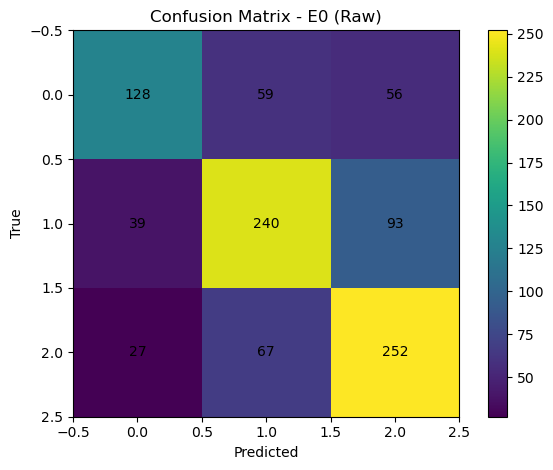

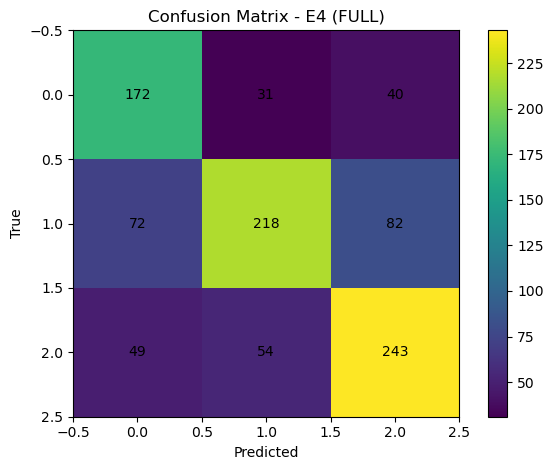

In [132]:
display(results_df.sort_values("exp_id").reset_index(drop=True))

plot_confusion_matrix(cms["E0"], "Confusion Matrix - E0 (Raw)")
plot_confusion_matrix(cms["E4"], "Confusion Matrix - E4 (FULL)")


## 9) Optional: Error Analysis (Inspect Misclassifications)

To better understand *why* preprocessing helps, we can inspect a few misclassified examples
(using the FULL pipeline E4).


In [133]:
# Re-run E4 to explicitly obtain predictions (kept explicit for clarity)
e4_pred = evaluate_experiment(
    exp_id="E4",
    name="FULL: remove @/#/url + slang + class_weight",
    transform=full_preprocess,
    class_weight="balanced",
)["y_pred"]

inv_label_map = {v: k for k, v in LABEL_MAP.items()}

err_df = pd.DataFrame({
    "text": X_test,
    "y_true": y_test,
    "y_pred": e4_pred,
})
err_df["true_label"] = err_df["y_true"].map(inv_label_map)
err_df["pred_label"] = err_df["y_pred"].map(inv_label_map)

errors = err_df[err_df["y_true"] != err_df["y_pred"]].copy()
print("Number of errors (E4):", len(errors))

# Show a few random errors
errors.sample(min(10, len(errors)), random_state=RANDOM_STATE)[["true_label", "pred_label", "text"]]

Number of errors (E4): 328


C:\Users\mhjv_\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,true_label,pred_label,text
671,negative,positive,Obviously not for vibrant and beautiful and yo...
337,neutral,positive,May bago na naman akong kaka-adikan. ?? #hopeless
725,neutral,positive,RT @EnthusiasticKAT: Karl-Anthony is enthusias...
18,neutral,positive,Airus crashes onto a deserted island. Will Har...
287,positive,negative,NEWS | Lozanovski finds the right balance for ...
637,neutral,positive,"RT @HoweMaster: Coffee number one is ""light"" h..."
910,negative,neutral,RT @LennoxLewis: This is what many black Ameri...
567,neutral,negative,"RT @itstotallyalii: I drew something but idk, ..."
582,negative,positive,Grab your brain mittens twitter I'm super ecst...
318,negative,neutral,Why are you feeling dejected? Take the quiz: h...


## 10) Conclusion

This notebook presents a reproducible pipeline for evaluating the impact of **text preprocessing** on a **Logistic Regression** sentiment classification model.

### Key Findings & Takeaways:
1.  **Baseline Performance**: TF-IDF combined with Logistic Regression provides a robust and interpretable baseline for text sentiment analysis.
2.  **Incremental Gains**: Individual preprocessing steps (noise removal, slang expansion) contribute to performance improvements.
3.  **Optimal Configuration**: The **FULL Pipeline (E4)** typically yields the most significant performance boost, particularly in **Macro-F1** score, demonstrating the synergy between text normalization and class balancing.
4.  **Methodological Rigor**: By encapsulating transformations within a pipeline and applying them strictly after the Train-Test split, we ensure zero data leakage and reliable evaluation metrics.